https://www.jphwang.com/posts/nba-shot-data-analytics-visualization-with-python-pandas-and-matplotlib-part-2-grouping-data-by-area/

for hexabin tutorial


https://medium.com/@amitparikh41/college-basketball-shot-mapping-with-python-23f543528b5f

shot chart mapping

Step 1: Setting Up the Environment and Helper Functions

We'll start with helper functions to fetch and save the list of players, get team abbreviations, and categorize shots.

In [6]:
%%writefile modular/nba_helpers.py

import requests
import pandas as pd
import os
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import commonallplayers
import numpy as np

def fetch_and_save_players_list():
    """Fetches the list of all players for specified seasons and saves it to a CSV file."""
    seasons = ["2023-24", "2022-23", "2021-22"]
    all_players = commonallplayers.CommonAllPlayers(is_only_current_season=0).get_data_frames()[0]

    players_data = []
    for season in seasons:
        for _, player in all_players.iterrows():
            players_data.append({
                'id': player['PERSON_ID'],
                'full_name': player['DISPLAY_FIRST_LAST'],
                'season': season
            })

    df = pd.DataFrame(players_data).drop_duplicates()
    df.to_csv('data/players_list.csv', index=False)

def load_players_list(season):
    """Loads the list of players for a specific season from a CSV file."""
    file_path = 'data/players_list.csv'
    if not os.path.exists(file_path):
        fetch_and_save_players_list()
    
    players_df = pd.read_csv(file_path)
    return players_df[players_df['season'] == season]

def get_team_abbreviation(team_name):
    """Gets the team abbreviation for a given team name."""
    team_dictionary = teams.get_teams()
    team_info = [team for team in team_dictionary if team['full_name'] == team_name]
    if not team_info:
        raise ValueError(f"No team found with name {team_name}")
    return team_info[0]['abbreviation']

def categorize_shot(row):
    """Categorizes a shot based on its location."""
    x, y = row['LOC_X'], row['LOC_Y']
    if y > 237.5:
        if x < -80:
            return 'Left Corner 3', '24+ ft'
        elif x < 80:
            return 'Left Wing 3', '24+ ft'
        else:
            return 'Right Corner 3', '24+ ft'
    elif y > 142.5:
        if x < -80:
            return 'Left Wing 3', '24+ ft'
        elif x < 0:
            return 'Left Top of Key 3', '20-24 ft'
        else:
            return 'Right Top of Key 3', '20-24 ft'
    elif y > 47.5:
        if x < -80:
            return 'Left Baseline Mid-range', '10-20 ft'
        elif x < -10:
            return 'Left Elbow Mid-range', '10-20 ft'
        elif x < 10:
            return 'Center Mid-range', '10-20 ft'
        elif x < 80:
            return 'Right Elbow Mid-range', '10-20 ft'
        else:
            return 'Right Baseline Mid-range', '10-20 ft'
    elif y > 0:
        if x < -80:
            return 'Left of Near Basket', '0-10 ft'
        elif x < 80:
            return 'Center of Near Basket', '0-10 ft'
        else:
            return 'Right of Near Basket', '0-10 ft'
    elif np.sqrt(x**2 + y**2) > 280:
        return 'Long 3', 'Beyond 3-pt'
    else:
        return 'Backcourt', 'Beyond Half Court'

Overwriting modular/nba_helpers.py


In [ ]:
%%writefile modular/ml_helpers.py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

def load_and_prepare_data(file_path, features):
    shots = pd.read_csv(file_path)
    X = shots[features]
    y = shots['SHOT_MADE_FLAG']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)
    return X_train_std, X_test_std, y_train, y_test

def plot_correlation_matrix(file_path, features):
    shots = pd.read_csv(file_path)
    correlation_matrix = shots[features + ['SHOT_MADE_FLAG']].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
    return correlation_matrix



In [ ]:
%%writefile modular/classifier_models.py

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

def train_logistic_regression(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

def train_svm(X_train, y_train):
    model = SVC(kernel='rbf', C=1.0, gamma=0.1)
    model.fit(X_train, y_train)
    return model

def train_decision_tree(X_train, y_train):
    model = DecisionTreeClassifier(max_depth=5)
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(X_train, y_train)
    return model

def train_knn(X_train, y_train):
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def train_naive_bayes(X_train, y_train):
    model = GaussianNB()
    model.fit(X_train, y_train)
    return model

def train_gradient_boosting(X_train, y_train):
    model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


Step 2: Fetching Shots Data

Next, we'll write functions to fetch shots data for both offensive and defensive sides.

In [7]:
%%writefile modular/nba_shots.py

import pandas as pd
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.static import players, teams
from modular.nba_helpers import get_team_abbreviation

def fetch_shots_data(name, is_team, season, opponent_team=None, game_date=None):
    """Fetches shots data for a team or player for a given season with optional filters."""
    if is_team:
        team_dictionary = teams.get_teams()
        team_info = [team for team in team_dictionary if team['full_name'] == name]
        
        if not team_info:
            raise ValueError(f"No team found with name {name}")
        
        team_id = team_info[0]['id']
        print(f"Fetching data for Team ID: {team_id}")
        
        shotchart = shotchartdetail.ShotChartDetail(
            team_id=team_id,
            player_id=0,
            context_measure_simple='FGA',
            season_nullable=season,
            season_type_all_star=['Regular Season', 'Playoffs']
        )
    else:
        player_dictionary = players.get_players()
        player_info = [player for player in player_dictionary if player['full_name'] == name]
        
        if not player_info:
            raise ValueError(f"No player found with name {name}")
        
        player_id = player_info[0]['id']
        print(f"Fetching data for Player ID: {player_id}")
        
        shotchart = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,
            context_measure_simple='FGA',
            season_nullable=season,
            season_type_all_star=['Regular Season', 'Playoffs']
        )
    
    data = shotchart.get_data_frames()[0]

    if opponent_team:
        opponent_abbreviation = get_team_abbreviation(opponent_team)
        data = data[(data['HTM'] == opponent_abbreviation) | (data['VTM'] == opponent_abbreviation)]
    
    if game_date:
        data = data[data['GAME_DATE'] == game_date.replace('-', '')]

    return data

def fetch_defensive_shots_data(team_name, season, opponent_team=None, game_date=None):
    """Fetches defensive shots data for a given team and season with optional filters."""
    team_abbr = get_team_abbreviation(team_name)
    shotchart = shotchartdetail.ShotChartDetail(
        team_id=0,
        player_id=0,
        context_measure_simple='FGA',
        season_nullable=season,
        season_type_all_star=['Regular Season', 'Playoffs']
    )
    
    data = shotchart.get_data_frames()[0]
    defensive_shots = data[(data['HTM'] == team_abbr) | (data['VTM'] == team_abbr)]
    defensive_shots = defensive_shots[defensive_shots['TEAM_NAME'] != team_name]

    if opponent_team:
        opponent_abbreviation = get_team_abbreviation(opponent_team)
        defensive_shots = defensive_shots[(defensive_shots['HTM'] == opponent_abbreviation) | (defensive_shots['VTM'] == opponent_abbreviation)]

    if game_date:
        defensive_shots = defensive_shots[defensive_shots['GAME_DATE'] == game_date.replace('-', '')]

    return defensive_shots

Overwriting modular/nba_shots.py


Step 3: Plotting Functions

We'll create functions to plot the court and shot charts.

In [8]:
%%writefile modular/nba_plotting.py

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_court(ax=None):
    """Plots the basketball court on a given axis."""
    if ax is None:
        ax = plt.gca()
    
    ax.set_xlim(-250, 250)
    ax.set_ylim(-47.5, 422.5)
    ax.set_aspect('equal')
    
    court_elements = [
        plt.Circle((0, 0), radius=7.5, linewidth=2, color='black', fill=False),  # Hoop
        plt.Rectangle((-30, -10), 60, -1, linewidth=2, color='black'),  # Backboard
        plt.Rectangle((-80, -47.5), 160, 190, linewidth=2, color='black', fill=False),  # Paint
        plt.Circle((0, 142.5), radius=60, linewidth=2, color='black', fill=False),  # Free throw top arc
        plt.Circle((0, 142.5), radius=60, linewidth=2, color='black', fill=False, linestyle='dashed'),  # Free throw bottom arc
        patches.Arc((0, 0), 475, 475, theta1=0, theta2=180, linewidth=2, color='black'),  # 3-point arc
        plt.Rectangle((-250, -47.5), 500, 470, linewidth=2, color='black', fill=False),  # Outer lines
    ]
    
    for element in court_elements:
        ax.add_patch(element)
    
    return ax

def plot_shot_chart_hexbin(shots, title, court_color='white'):
    """Plots a hexbin shot chart."""
    plt.figure(figsize=(12, 11))
    ax = plt.gca()
    ax.set_facecolor(court_color)
    plot_court(ax)
    
    hexbin = plt.hexbin(
        shots['LOC_X'], shots['LOC_Y'], C=shots['SHOT_MADE_FLAG'], 
        gridsize=40, extent=(-250, 250, -47.5, 422.5), cmap='Blues', edgecolors='grey'
    )
    
    cb = plt.colorbar(hexbin, ax=ax, orientation='vertical')
    cb.set_label('Shooting Percentage')
    
    total_attempts = len(shots)
    total_made = shots['SHOT_MADE_FLAG'].sum()
    overall_percentage = total_made / total_attempts if total_attempts > 0 else 0
    
    plt.text(0, 450, f"Total Shots: {total_attempts}", fontsize=12, ha='center')
    plt.text(0, 430, f"Total Made: {total_made}", fontsize=12, ha='center')
    plt.text(0, 410, f"Overall Percentage: {overall_percentage:.2%}", fontsize=12, ha='center')
    
    plt.title(title)
    plt.xlim(-250, 250)
    plt.ylim(-47.5, 422.5)
    return plt.gcf()

Overwriting modular/nba_plotting.py


Step 4: Efficiency Calculation Functions

We'll write functions to calculate shot efficiency and team fit.

In [9]:
%%writefile modular/nba_efficiency.py

import pandas as pd
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from modular.nba_helpers import categorize_shot
from modular.nba_shots import fetch_shots_data, fetch_defensive_shots_data

def calculate_efficiency(shots):
    """Calculates the efficiency of shots."""
    shots['Area'], shots['Distance'] = zip(*shots.apply(categorize_shot, axis=1))
    summary = shots.groupby(['Area', 'Distance']).agg(
        Attempts=('SHOT_MADE_FLAG', 'size'),
        Made=('SHOT_MADE_FLAG', 'sum')
    ).reset_index()
    summary['Efficiency'] = summary['Made'] / summary['Attempts']
    return summary

def calculate_team_fit(home_efficiency, opponent_efficiency):
    """Calculates the team fit using MAE and MAPE."""
    # Find common areas
    common_areas = set(home_efficiency['Area']).intersection(set(opponent_efficiency['Area']))
    
    home_efficiency_common = home_efficiency[home_efficiency['Area'].isin(common_areas)]
    opponent_efficiency_common = opponent_efficiency[opponent_efficiency['Area'].isin(common_areas)]
    
    # Calculate MAE and MAPE
    mae = mean_absolute_error(home_efficiency_common['Efficiency'], opponent_efficiency_common['Efficiency'])
    mape = mean_absolute_percentage_error(home_efficiency_common['Efficiency'], opponent_efficiency_common['Efficiency'])
    
    return mae, mape

def create_mae_table(home_team, season, all_teams):
    """Creates a table of MAE values for the given home team against all opponents."""
    mae_list = []
    for opponent in all_teams:
        if opponent == home_team:
            continue
        home_shots = fetch_shots_data(home_team, True, season)
        opponent_shots = fetch_defensive_shots_data(opponent, season)
        
        home_efficiency = calculate_efficiency(home_shots)
        opponent_efficiency = calculate_efficiency(opponent_shots)
        
        mae, mape = calculate_team_fit(home_efficiency, opponent_efficiency)
        
        mae_list.append({
            'Home Team': home_team,
            'Opponent Team': opponent,
            'MAE': mae,
            'MAPE': mape
        })
    
    mae_df = pd.DataFrame(mae_list)
    mae_df = mae_df.sort_values(by='MAE')
    return mae_df

def save_mae_table(mae_df):
    """Saves the MAE table to a CSV file."""
    file_path = 'data/mae_table.csv'
    mae_df.to_csv(file_path, index=False)

def load_mae_table():
    """Loads the MAE table from a CSV file if it exists."""
    file_path = 'data/mae_table.csv'
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    return None


Overwriting modular/nba_efficiency.py


Step 5: Main Function

Finally, we'll create the main function that ties everything together and performs the analysis.

Fetching data for Team ID: 1610612738
              GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID   PLAYER_NAME  \
3703  Shot Chart Detail  0022300611              7    1627759  Jaylen Brown   
3704  Shot Chart Detail  0022300611             10     201143    Al Horford   
3705  Shot Chart Detail  0022300611             29     201950  Jrue Holiday   
3706  Shot Chart Detail  0022300611             33     201950  Jrue Holiday   
3707  Shot Chart Detail  0022300611             35    1627759  Jaylen Brown   

         TEAM_ID       TEAM_NAME  PERIOD  MINUTES_REMAINING  \
3703  1610612738  Boston Celtics       1                 11   
3704  1610612738  Boston Celtics       1                 11   
3705  1610612738  Boston Celtics       1                  9   
3706  1610612738  Boston Celtics       1                  9   
3707  1610612738  Boston Celtics       1                  9   

      SECONDS_REMAINING  ...         SHOT_ZONE_AREA  SHOT_ZONE_RANGE  \
3703                 49  ...        

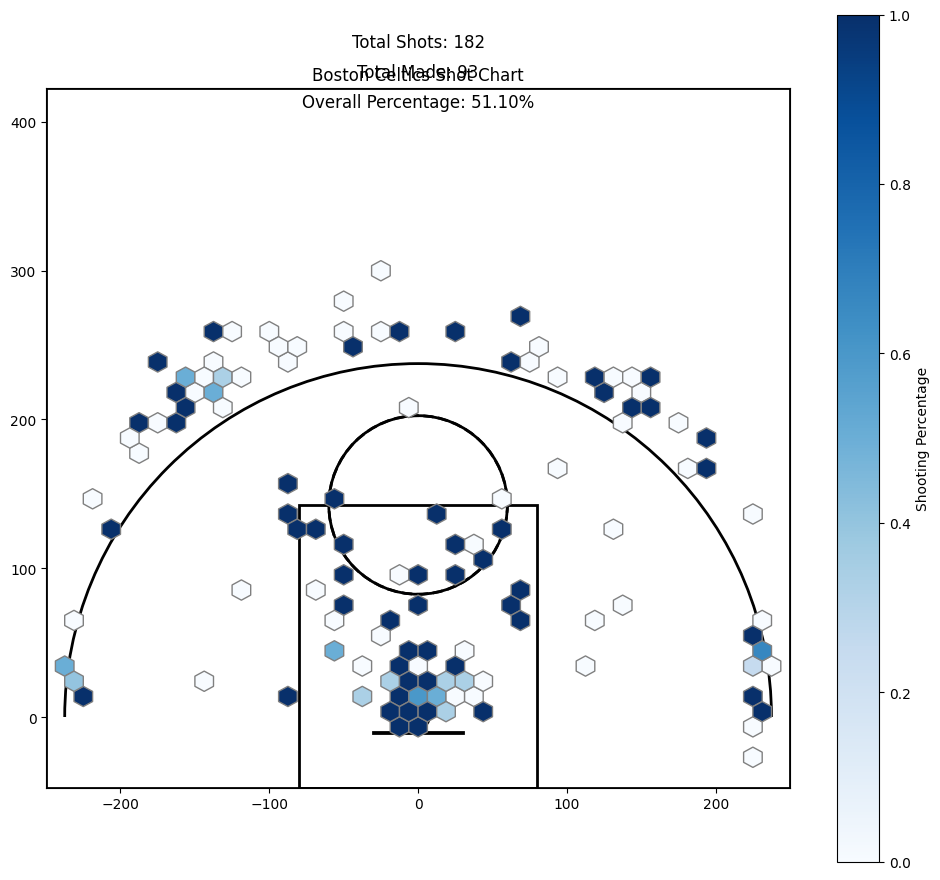

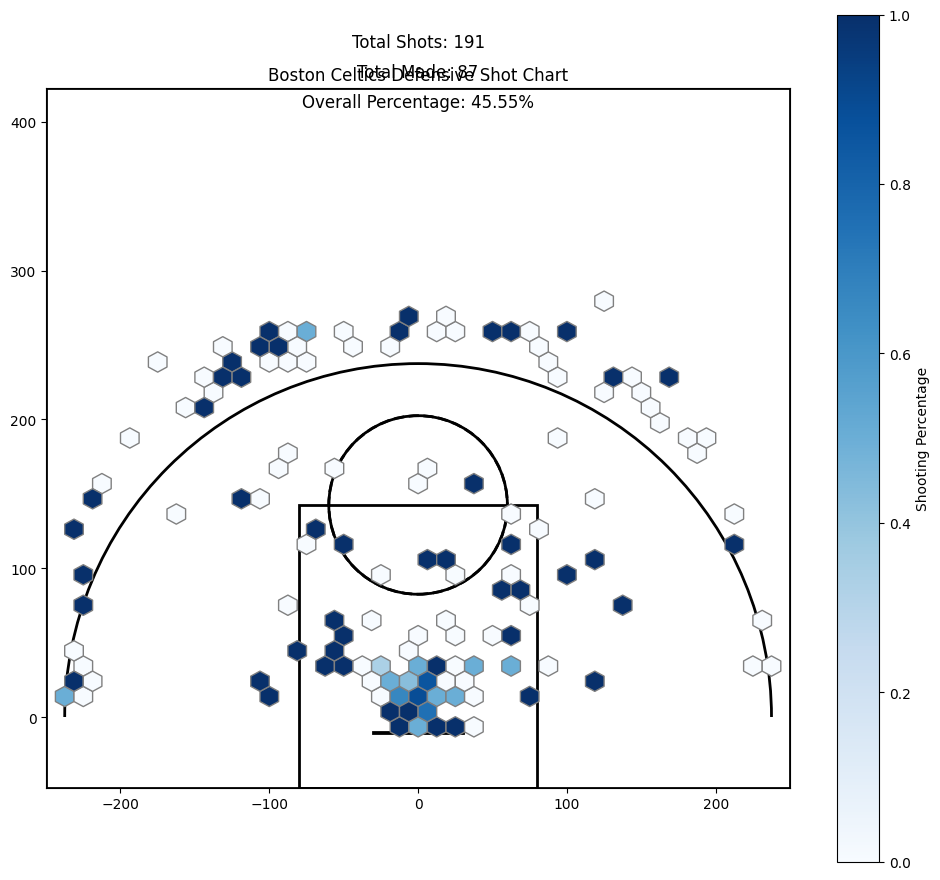

Defensive Efficiency:
                        Area           Distance  Attempts  Made  Efficiency
0                  Backcourt  Beyond Half Court         8     5    0.625000
1           Center Mid-range           10-20 ft         2     1    0.500000
2      Center of Near Basket            0-10 ft        66    39    0.590909
3    Left Baseline Mid-range           10-20 ft         5     3    0.600000
4              Left Corner 3             24+ ft        10     4    0.400000
5       Left Elbow Mid-range           10-20 ft         7     4    0.571429
6          Left Top of Key 3           20-24 ft         1     0    0.000000
7                Left Wing 3             24+ ft        31    10    0.322581
8        Left of Near Basket            0-10 ft        13     6    0.461538
9   Right Baseline Mid-range           10-20 ft         8     4    0.500000
10            Right Corner 3             24+ ft         4     1    0.250000
11     Right Elbow Mid-range           10-20 ft        13     6   

In [12]:
#%%writefile modular/main.py

import os
import pandas as pd
from nba_api.stats.static import players, teams
import matplotlib.pyplot as plt
from modular.nba_helpers import fetch_and_save_players_list, load_players_list, get_team_abbreviation, categorize_shot
from modular.nba_shots import fetch_shots_data, fetch_defensive_shots_data
from modular.nba_plotting import plot_shot_chart_hexbin
from modular.nba_efficiency import calculate_efficiency, calculate_team_fit, create_mae_table, save_mae_table, load_mae_table

def main():
    home_team = 'Boston Celtics'  # Change this to the team or player name
    season = '2023-24'
    analysis_type = 'both'  # Change to 'offensive', 'defensive', or 'both'
    opponent_team = 'Dallas Mavericks'  # Set to the opponent team name if needed
    game_date = ''  # Optional: 'YYYY-MM-DD'
    
    all_teams = [team['full_name'] for team in teams.get_teams()]
    
    try:
        if analysis_type in ['offensive', 'both']:
            shots = fetch_shots_data(home_team, True, season, opponent_team, game_date)
            unique_dates = shots['GAME_DATE'].unique()
            print(shots.head())
            
            season_efficiency = calculate_efficiency(shots)
            print("Season Averages:")
            print(season_efficiency)
            
            fig = plot_shot_chart_hexbin(shots, f'{home_team} Shot Chart')
            plt.show()
        
        if analysis_type in ['defensive', 'both']:
            defensive_shots = fetch_defensive_shots_data(home_team, season, opponent_team, game_date)
            fig = plot_shot_chart_hexbin(defensive_shots, f'{home_team} Defensive Shot Chart')
            plt.show()
            
            defensive_efficiency = calculate_efficiency(defensive_shots)
            print("Defensive Efficiency:")
            print(defensive_efficiency)
        
        if analysis_type == 'both':
            mae_df = load_mae_table()
            if mae_df is None:
                mae_df = create_mae_table(home_team, season, all_teams)
                save_mae_table(mae_df)
            print(mae_df)
        
    except Exception as e:
        print(f"Error fetching or plotting data: {e}")


if __name__ == "__main__":
    main()

In [ ]:
import modular.helpers as helpers
import modular.classifier_models as classifiers

def main(file_path, features):
    # Plot the correlation matrix
    correlation_matrix = helpers.plot_correlation_matrix(file_path, features)
    print(correlation_matrix)

    # Load and prepare data
    X_train_std, X_test_std, y_train, y_test = helpers.load_and_prepare_data(file_path, features)
    
    models = {
        'Logistic Regression': classifiers.train_logistic_regression,
        'SVM': classifiers.train_svm,
        'Decision Tree': classifiers.train_decision_tree,
        'Random Forest': classifiers.train_random_forest,
        'KNN': classifiers.train_knn,
        'Naive Bayes': classifiers.train_naive_bayes,
        'Gradient Boosting': classifiers.train_gradient_boosting
    }
    
    results = {}
    
    for model_name, train_func in models.items():
        model = train_func(X_train_std, y_train)
        accuracy = classifiers.evaluate_model(model, X_test_std, y_test)
        results[model_name] = accuracy
    
    for model_name, accuracy in results.items():
        print(f'{model_name} Accuracy: {accuracy:.2f}')

if __name__ == "__main__":
    file_path = 'data/shots_data.csv'  # Replace with your actual data file path
    features = ['LOC_X', 'LOC_Y', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING']  # Add or remove features here
    main(file_path, features)
